# GradientSHAP

This provided Jupyter Notebook cell showcases an example workflow for performing instance segmentation, visualization, and attribution on an input image using pre-trained models and libraries in Python. It begins by importing necessary libraries for image processing, model loading, visualization, and attribution. Then, it checks the availability of a GPU and loads the pre-trained Mask R-CNN ResNet-50 model for instance segmentation and the pre-trained ResNet-50 model for classification.

Next, it defines the input image, performs instance segmentation using the Mask R-CNN model, and retrieves the top predicted masks, labels, and bounding boxes. The code overlays the colored masks and bounding boxes on the original image, generates unique colors for each detection, and adds ID and class labels to the bounding boxes. It also crops the region of interest for each detection and stores the cropped images.

The workflow continues by combining the original image with the overlay, converting it to RGB mode, and displaying the image with overlaid masks and bounding boxes. Finally, it performs GradientShap attribution on the cropped images using the classification model and visualizes the attributions by generating heat maps. The resulting cropped images are displayed along with their respective class labels and IDs.

This example provides a practical demonstration of using pre-trained models and libraries to perform instance segmentation, visualization, and attribution on an image, allowing for better understanding and interpretation of the model's predictions.

This Jupyter notebook is based on:

* https://captum.ai/docs/attribution_algorithms#gradient-shap
*https://proceedings.neurips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html


#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [1]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using GradientSHAP
he input image is defined and transformed into a PyTorch tensor. Instance segmentation is performed using the Mask R-CNN model, and the top predicted masks, labels, and bounding boxes are retrieved.

Colored masks and bounding boxes are overlaid on the original image, and a unique color is generated for each detection. The bounding boxes are drawn, and class labels and IDs are added. The regions of interest are cropped and stored as separate images.

The resulting overlay image is displayed, and GradientShap attribution is performed on the cropped images using the classification model. Attribution heat maps are generated and visualized.

Finally, the cropped images, along with their respective class labels and IDs, are displayed in a grid format using matplotlib.

This implementation provides a concise and technical demonstration of performing instance segmentation and attribution on an image using pre-trained models and libraries in Python.

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 85.4MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for '

ID: 0, Class: 1, Score: 99.96%
ID: 1, Class: 1, Score: 99.94%
ID: 2, Class: 3, Score: 99.80%
ID: 3, Class: 3, Score: 99.28%
ID: 4, Class: 10, Score: 99.10%
ID: 5, Class: 1, Score: 98.97%
ID: 6, Class: 10, Score: 98.84%
ID: 7, Class: 3, Score: 97.60%
ID: 8, Class: 10, Score: 97.27%
ID: 9, Class: 27, Score: 95.66%
ID: 10, Class: 1, Score: 93.80%
ID: 11, Class: 10, Score: 93.11%
ID: 12, Class: 31, Score: 89.12%
ID: 13, Class: 10, Score: 88.22%
ID: 14, Class: 31, Score: 88.16%
ID: 15, Class: 1, Score: 86.22%
ID: 16, Class: 6, Score: 85.46%
ID: 17, Class: 10, Score: 83.78%
ID: 18, Class: 3, Score: 81.07%
ID: 19, Class: 31, Score: 78.01%


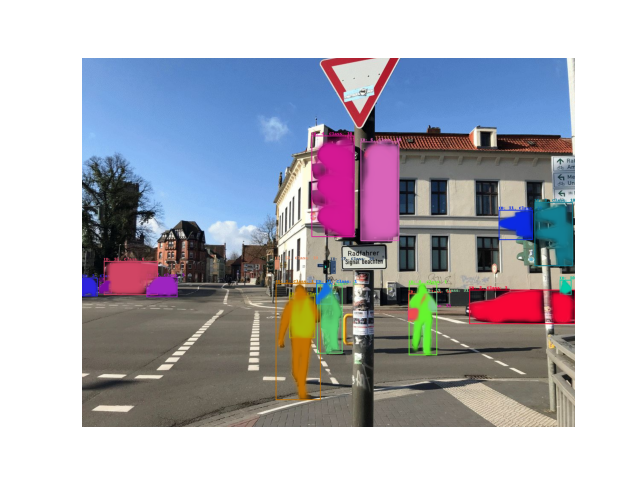

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet50
from captum.attr import GradientShap
from captum.attr import visualization as viz

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the pre-trained Mask R-CNN ResNet-50 model for instance segmentation
instance_model = maskrcnn_resnet50_fpn(pretrained=True)
instance_model.to(device)
instance_model.eval()

# Load the pre-trained ResNet-50 model for classification
classification_model = resnet50(pretrained=True)
classification_model.to(device)
classification_model.eval()

# Define the input image
image_path = '/content/drive/MyDrive/Colab Notebooks/images/multiple_tl.jpg'  # Update with your image path
img = Image.open(image_path).convert("RGB")
img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

# Perform instance segmentation using the Mask R-CNN model
with torch.no_grad():
    predictions = instance_model(img_tensor)

# Retrieve the top 20 predicted masks, labels, and bounding boxes
top_k = min(20, predictions[0]['masks'].shape[0])
masks = predictions[0]['masks'][:top_k].detach().cpu().numpy()
labels = predictions[0]['labels'][:top_k].detach().cpu().numpy()
boxes = predictions[0]['boxes'][:top_k].detach().cpu().numpy()
scores = predictions[0]['scores'][:top_k].detach().cpu().numpy()

# Create a blank image with RGBA mode
img_overlay = Image.new("RGBA", img.size)

# Initialize a list to store the cropped images
cropped_images = []

# Overlay the colored masks and bounding boxes on the original image
for i in range(masks.shape[0]):
    mask = masks[i, 0]  # Select the mask for the current instance
    label = labels[i]  # Select the label for the current instance
    box = boxes[i]  # Select the bounding box for the current instance

    # Generate a unique color for the current detection
    color = tuple(np.random.randint(0, 256, 3))

    # Convert the mask to PIL Image
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))

    # Resize the mask to match the original image size
    mask_img = mask_img.resize(img.size, resample=Image.BILINEAR)

    # Create a solid color image using the color and the mask
    color_img = Image.new("RGBA", img.size, color)
    color_img.putalpha(mask_img)

    # Blend the colored mask with the original image
    img_overlay = Image.alpha_composite(img_overlay, color_img)

    # Draw the bounding box on the original image
    draw = ImageDraw.Draw(img)
    draw.rectangle(box.tolist(), outline=color, width=2)

    # Add ID and class label to the bounding box
    score = scores[i]  # Select the score for the current instance
    print(f'ID: {i}, Class: {label}, Score: {score*100:.2f}%')

    text = f'ID: {i}, Class: {label}'
    draw.text((box[0], box[1] - 10), text, fill=color)

    # Crop the region of interest using the bounding box coordinates
    cropped_img = img.crop(box.tolist())
    cropped_images.append(cropped_img)

# Combine the original image with the overlay
img_result = Image.alpha_composite(img.convert("RGBA"), img_overlay)

# Convert the result image to RGB mode
img_result = img_result.convert("RGB")

# Display the image with overlaid masks and bounding boxes
plt.imshow(img_result)
plt.axis('off')
plt.show()

#### XAI metrics

A low infidelity value close to 0 indicates that the explanation provided by the XAI method is relatively faithful to the model's behavior. It suggests that the generated explanation is a good representation of how the model arrived at its predictions, making it a reliable and accurate explanation.

A high sensitivity value indicates that the model is highly sensitive to changes in specific input features. In other words, small changes in those features can lead to substantial changes in the model's predictions. This suggests that the model heavily relies on the identified features to make its decisions.

Class: 1, ID: 0 Infidelity: 0.0002580451255198568
Class: 1, ID: 0 Sensitivity: 1.407993197441101


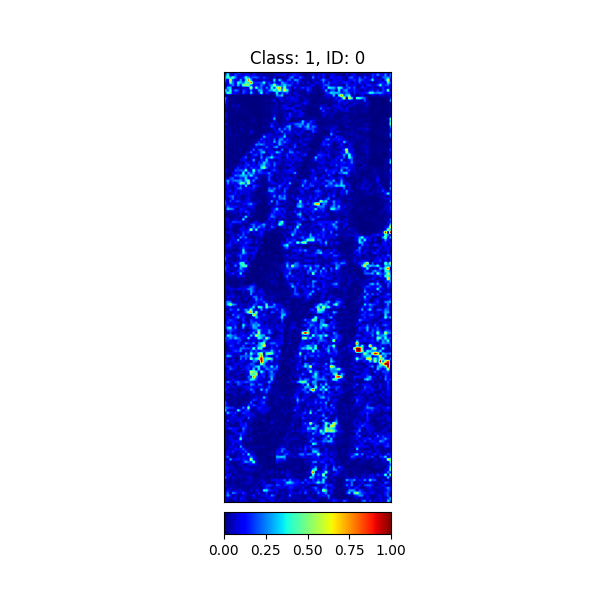

Class: 1, ID: 1 Infidelity: 0.00017041392857208848
Class: 1, ID: 1 Sensitivity: 1.5694050788879395


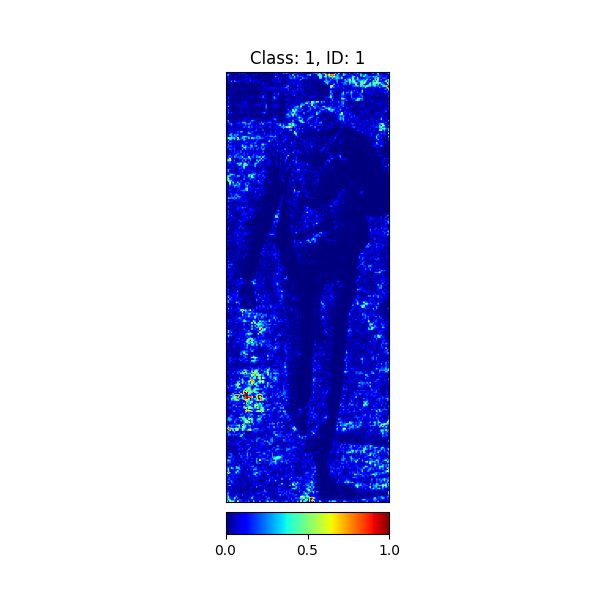

Class: 3, ID: 2 Infidelity: 0.002614000579342246
Class: 3, ID: 2 Sensitivity: 0.9070374965667725


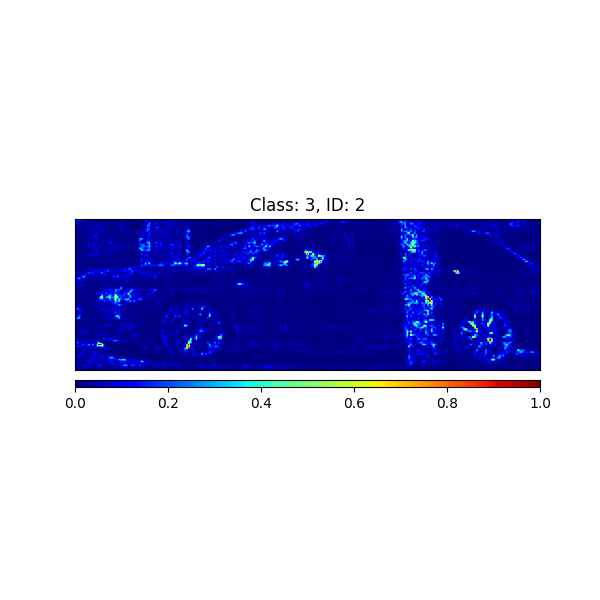

Class: 3, ID: 3 Infidelity: 0.006297750864177942
Class: 3, ID: 3 Sensitivity: 0.8461771011352539


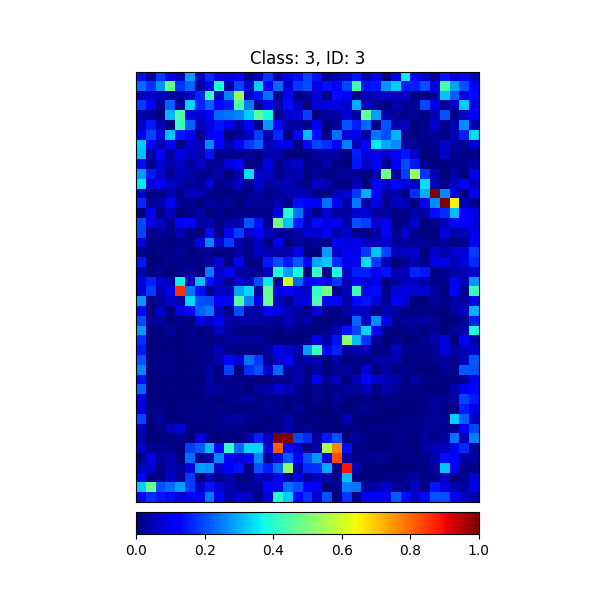

Class: 10, ID: 4 Infidelity: 0.0012021029833704233
Class: 10, ID: 4 Sensitivity: 1.0837887525558472


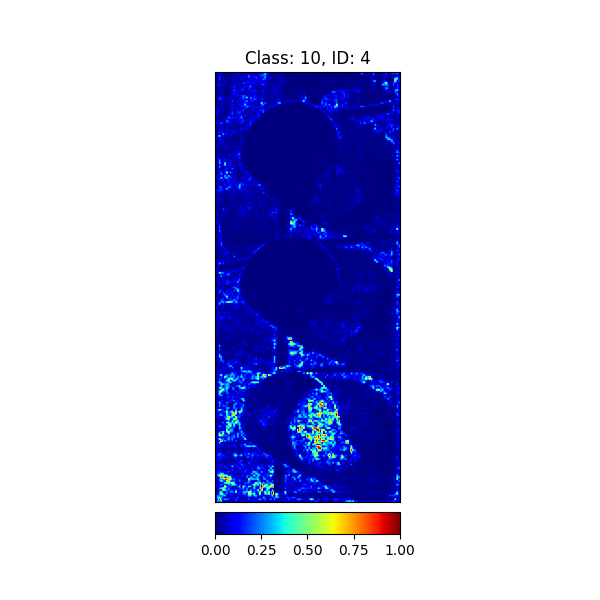

Class: 1, ID: 5 Infidelity: 0.001299835043027997
Class: 1, ID: 5 Sensitivity: 1.6780191659927368


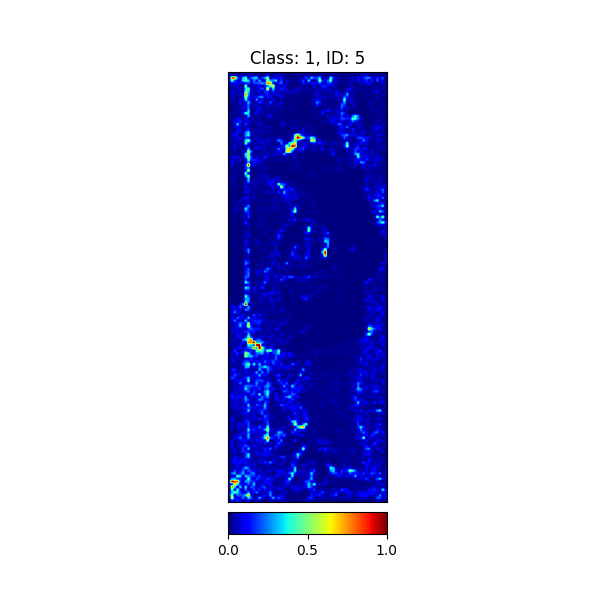

Class: 10, ID: 6 Infidelity: 0.0018193261930719018
Class: 10, ID: 6 Sensitivity: 1.2121171951293945


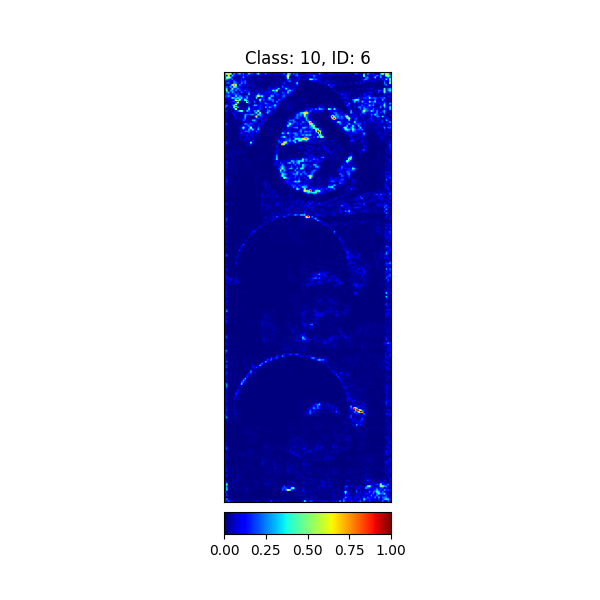

Class: 3, ID: 7 Infidelity: 0.0006248910212889314
Class: 3, ID: 7 Sensitivity: 1.4415881633758545


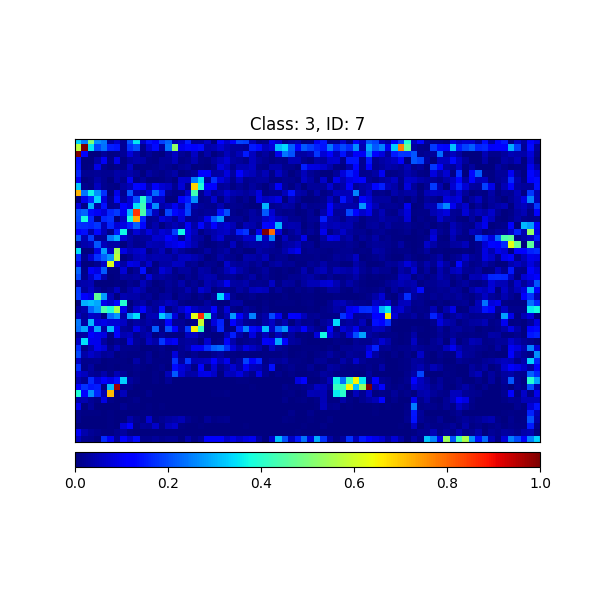

Class: 10, ID: 8 Infidelity: 0.001408751355484128
Class: 10, ID: 8 Sensitivity: 1.014533519744873


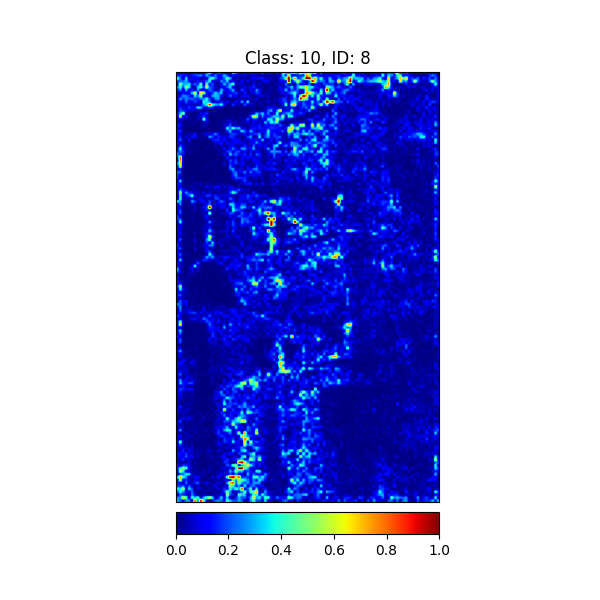

Class: 27, ID: 9 Infidelity: 0.0002574917452875525
Class: 27, ID: 9 Sensitivity: 1.1675740480422974


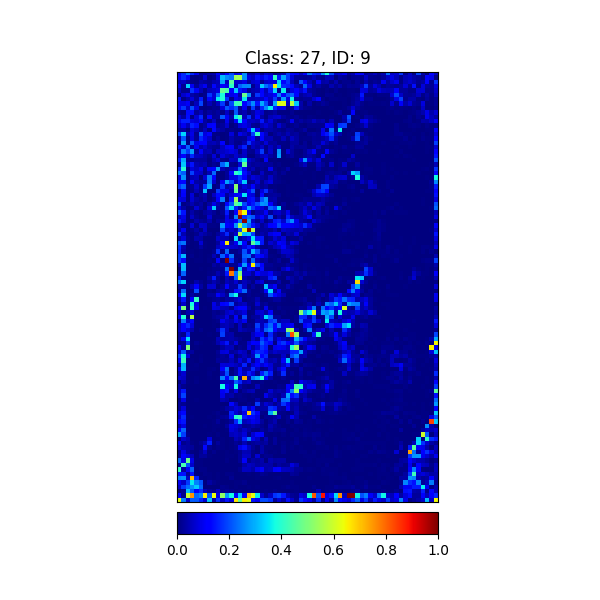

Class: 1, ID: 10 Infidelity: 0.001419046544469893
Class: 1, ID: 10 Sensitivity: 1.1369529962539673


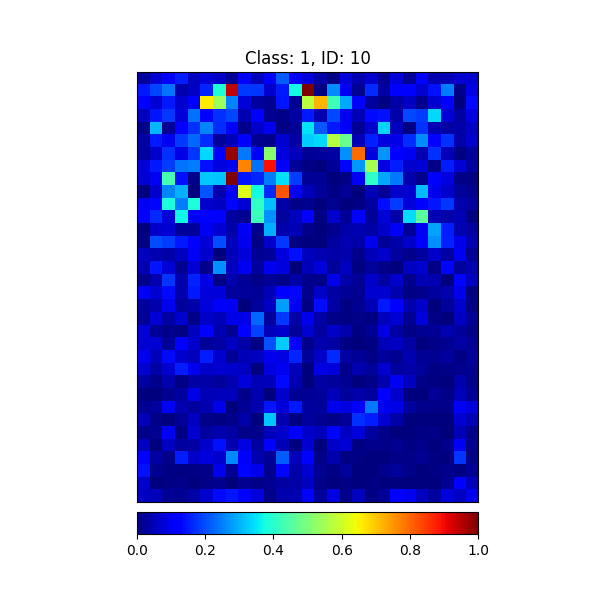

Class: 10, ID: 11 Infidelity: 0.001485298154875636
Class: 10, ID: 11 Sensitivity: 1.3458967208862305


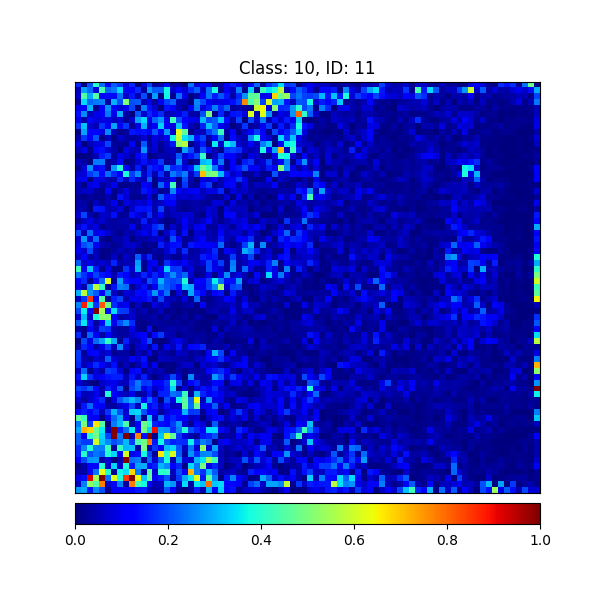

Class: 31, ID: 12 Infidelity: 0.0007269129273481667
Class: 31, ID: 12 Sensitivity: 1.173864483833313


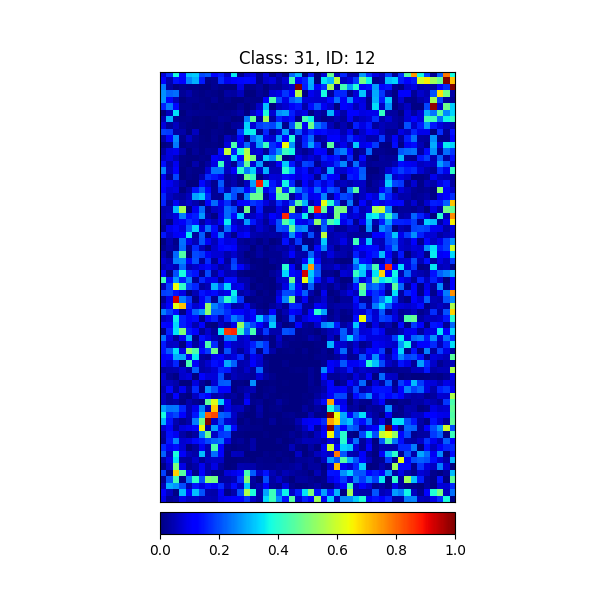

Class: 31, ID: 13 Infidelity: 0.0025372954551130533
Class: 31, ID: 13 Sensitivity: 1.1649413108825684


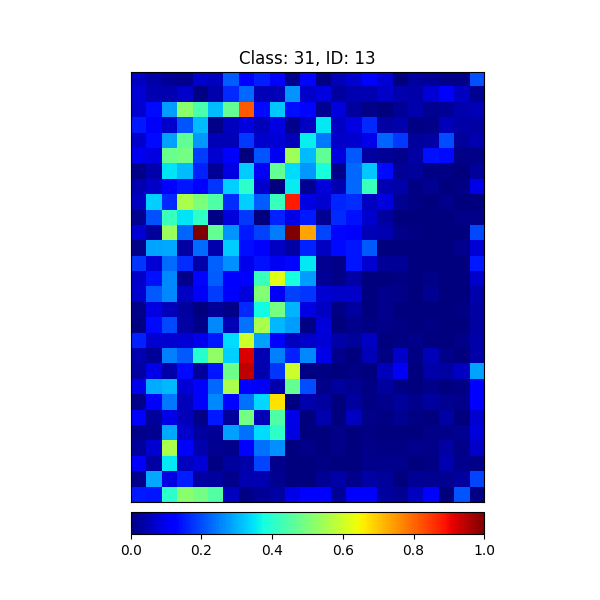

Class: 10, ID: 14 Infidelity: 0.000192574443644844
Class: 10, ID: 14 Sensitivity: 1.2085379362106323


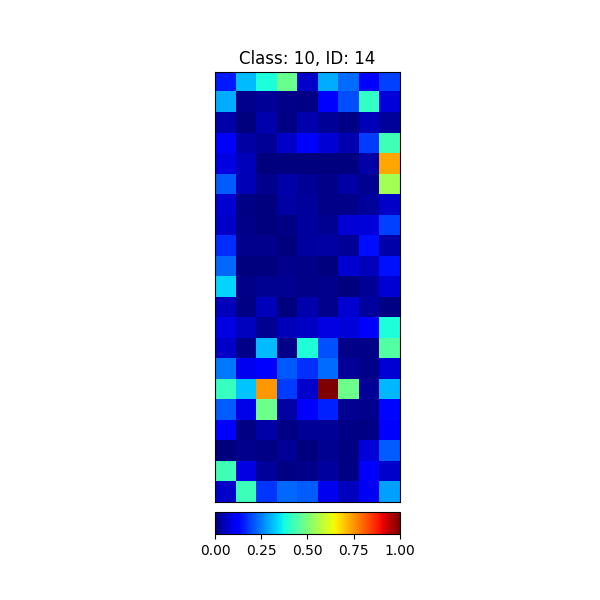

Class: 1, ID: 15 Infidelity: 0.002246134215965867
Class: 1, ID: 15 Sensitivity: 0.8921972513198853


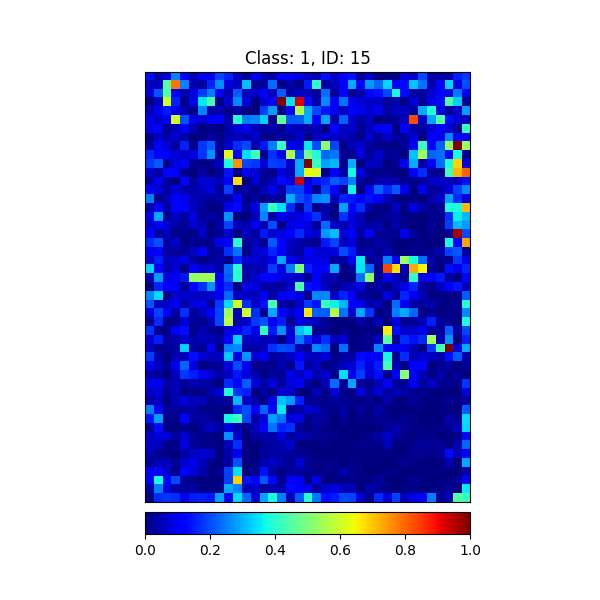

Class: 6, ID: 16 Infidelity: 0.0037296819500625134
Class: 6, ID: 16 Sensitivity: 1.1070618629455566


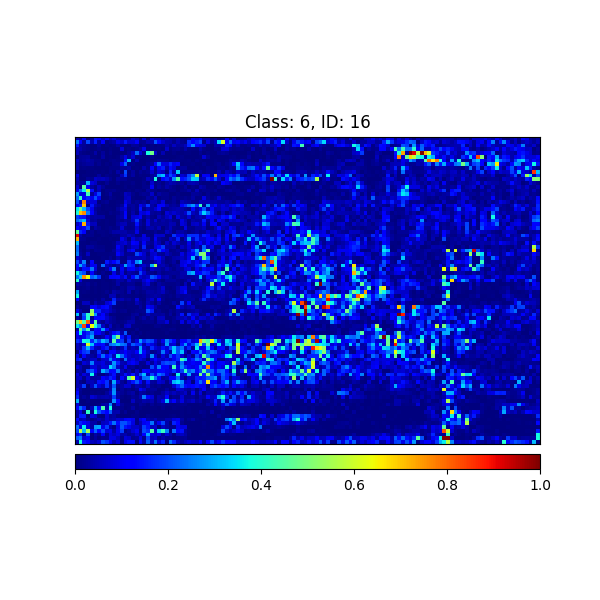

Class: 10, ID: 17 Infidelity: 0.0008226812933571637
Class: 10, ID: 17 Sensitivity: 1.2676764726638794


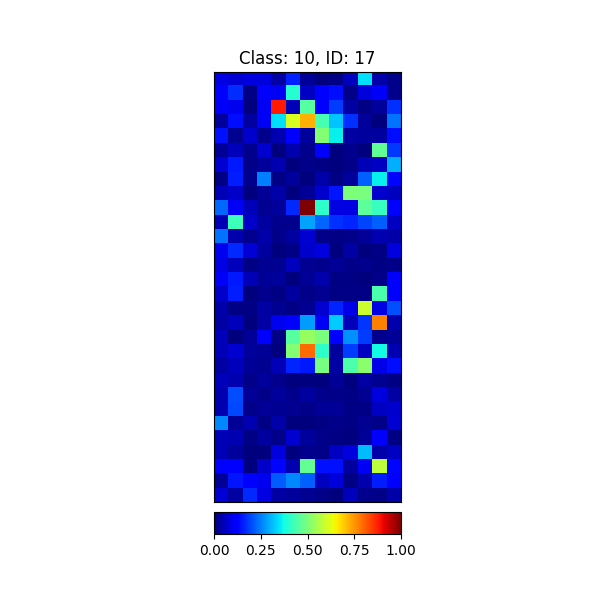

Class: 1, ID: 18 Infidelity: 0.0007911041611805558
Class: 1, ID: 18 Sensitivity: 1.0527679920196533


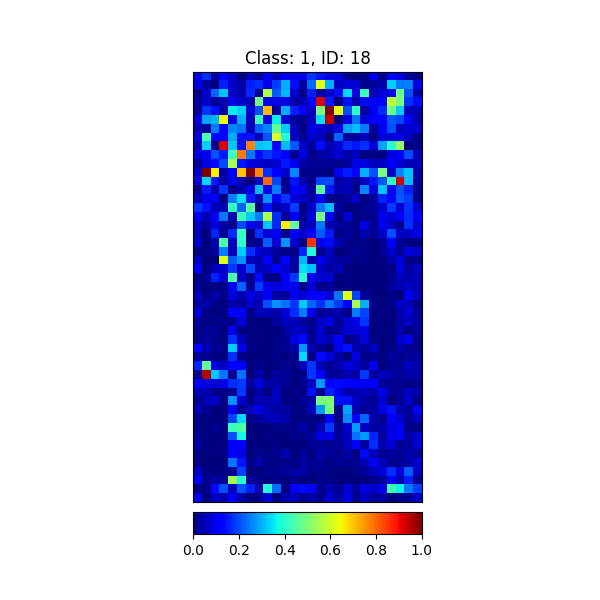

Class: 3, ID: 19 Infidelity: 0.0009158411994576454
Class: 3, ID: 19 Sensitivity: 1.06122624874115


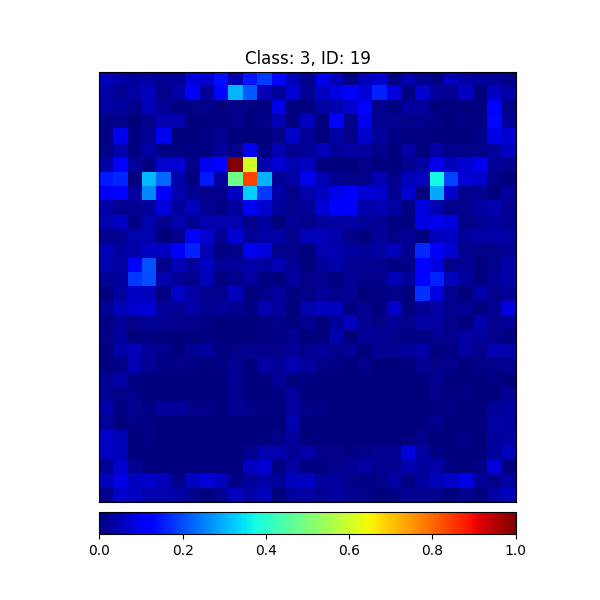

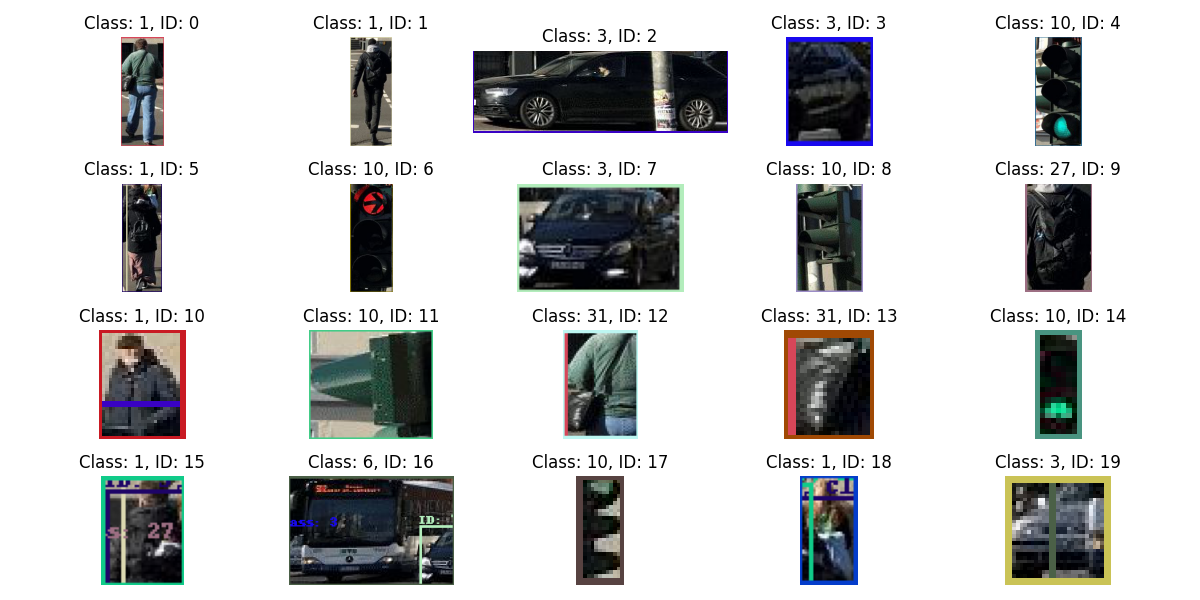

In [ ]:
from captum.metrics import infidelity, sensitivity_max
import numpy as np

# Define the perturbation function
def perturb_fn(inputs):
    # Multiplying by 0.003 scales the random values to control the magnitude of the perturbations.
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
    return noise, inputs - noise

# Perform GradientShap attribution on the cropped images
gs = GradientShap(classification_model)

attributions = []

for i, img in enumerate(cropped_images):
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
    baseline = torch.zeros_like(img_tensor)

    with torch.no_grad():
        attr_gs = gs.attribute(img_tensor, baseline, target=torch.tensor([labels[i]]))
         # Wrapper function for lr_lime.attribute
        def gs_attr(inputs):
            return gs.attribute(inputs, baseline, target=torch.tensor([labels[i]]))
        sens = sensitivity_max(gs_attr, img_tensor)

     # Compute the infidelity
    infid = infidelity(classification_model, perturb_fn, img_tensor, attr_gs, target=torch.tensor([labels[i]]))
    print(f"Class: {labels[i]}, ID: {i} Infidelity: {infid.item()}")

    # Calculate Sensitivity
    print(f"Class: {labels[i]}, ID: {i} Sensitivity: {sens.item()}")

    _ = viz.visualize_image_attr(np.transpose(attr_gs.squeeze().cpu().detach().numpy(), (1,2,0)), show_colorbar=True, title=f'Class: {labels[i]}, ID: {i}', method="heat_map", cmap='jet')

# Visualize the attributions
fig = plt.figure(figsize=(12, 6))
columns = 5
rows = (top_k - 1) // columns + 1

for i, img in enumerate(cropped_images):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Class: {labels[i]}, ID: {i}')

plt.tight_layout()
plt.show()